# Yearly Air Quality of India

In this notebook I will perform exploratory analysis on the dataset files. I will focus on per-state analytics and predictions.

## Import Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Load State Information

First we define the state and its appropriate code for reference as well as all the available metrics.

In [2]:
df_states = pd.read_csv('dataset/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [3]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

As we can see, we can find the appropriate code files for each state that we want to see the analytics for.

## Data Preprocessing

In [4]:
def get_state_df(state_name):
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'dataset/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')
    return pd.concat(map(pd.read_csv, state_files))

In [5]:
state = 'Delhi'
df = get_state_df(state)

Combining a total of 40 files...



Quickly examine the loaded combined dataset from all cities in the selected state.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796171 entries, 0 to 20841
Data columns (total 59 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  O Xylene (ug/m3)     float64
 16  Temp (degree C)      float64
 17  RH (%)               float64
 18  WS (m/s)             float64
 19  WD (deg)             float64
 20  SR (W/mt2)           float64
 21  BP (mmHg)            float64
 22  VWS (m/s)            float64
 23  Xylene (ug/m3)       float64
 24  

### Missing Values

Let's check the ratio of missing values for the above columns.

In [7]:
def compare_nulls(df):
    null_vals = df.isnull().sum()

    df_null_vals = pd.concat({'Records': df.notnull().sum(),
                              'Null Count': null_vals,
                              'Percent Missing (%)': round(null_vals * 100 / len(df), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

print(f'This dataset contains {len(df.columns)} features.')
compare_nulls(df).head(15)

This dataset contains 59 features.


,Records,Null Count,Percent Missing (%)
NMHC (ug/m3),0,2796171,100.00
SPM (ug/m3),0,2796171,100.00
Gust (km/hr),0,2796171,100.00
Eth-Benzene (),0,2796171,100.00
Variance (n),0,2796171,100.00
Power (W),0,2796171,100.00
CO2 (mg/m3),0,2796171,100.00
Temp (ug/m3),0,2796171,100.00
Gust (kl/h),0,2796171,100.00
Gust (m/s),0,2796171,100.00


We can clearly see that the dataset contains a lot of missing values, which we will have to deal with.<br>
So let's clean this dataset in various ways:

1. I make one of the dates as index and make sure to change its Dtype to datetime format.
2. Remove the rows and columns that contain only missing values.

In [8]:
def clean_df(df, rows_only=False):
    # Make the 'To Date' column the index as datetime
    df.drop(columns='From Date', inplace=True)
    df['To Date'] = pd.to_datetime(df['To Date'])
    df.rename(columns={'To Date': 'datetime'}, inplace=True)
    df.set_index('datetime', inplace=True)

    # Drop all columns and rows that only contain missing values
    df.dropna(how='all', inplace=True)
    if not rows_only:
        df.dropna(how='all', axis='columns', inplace=True)
    return df

df = clean_df(df)

In [9]:
compare_nulls(df).head(10)

,Records,Null Count,Percent Missing (%)
CH4 (),10828,2108826,99.49
MP-Xylene (),29205,2090449,98.62
HCHO (ug/m3),33828,2085826,98.40
Xylene (),34578,2085076,98.37
Hg (ug/m3),35151,2084503,98.34
MH (m),37448,2082206,98.23
SO2 (),39290,2080364,98.15
BP (),39508,2080146,98.14
RH (),39722,2079932,98.13
SR (),43267,2076387,97.96


### Feature Usage

Now we are left with a dataset that contains several features with high ratio of missing data.<br>
It would be wise to check the frequency of the all the features in all the various state files.

In [10]:
from IPython.display import clear_output

# Delete the previous dataframe
del df

features = {}
total_records = 0

for i, state_name in enumerate(unique_states):
    clear_output(wait=False)
    print(f"Processing state of {state_name} ({i+1}/{len(unique_states)})")
    df = get_state_df(state)
    df = clean_df(df, rows_only=True)
    comparisons = compare_nulls(df)
    
    total_records += df.shape[0]

    for feature in comparisons.index:
        if feature in features:
            features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
        else:
            features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

Processing state of West Bengal (31/31)
Combining a total of 40 files...



In [11]:
test_df = pd.DataFrame.from_dict(features, orient='index', columns=['Null Counts'])
test_df['Percent Missing (%)'] = round(test_df['Null Counts'] * 100 / total_records, 2)
test_df


,Null Counts,Percent Missing (%)
NMHC (ug/m3),65709274,100.00
Gust (km/hr),65709274,100.00
Eth-Benzene (),65709274,100.00
Temp (ug/m3),65709274,100.00
SPM (ug/m3),65709274,100.00
Gust (m/s),65709274,100.00
Gust (kl/h),65709274,100.00
CO2 (mg/m3),65709274,100.00
Power (W),65709274,100.00
Variance (n),65709274,100.00


We can clearly see that a vast majority of features contain missing values.

### Deeper Analysis - Elimination

From here we can drop the columns which contain a certain thrueshold (i.e 60%) of missing values.<br>
However I decided to make a deeper analysis to check if we have some similatiries in some columns.

For instance the columns `Xylene ()` and `Xylene (ug/m3)` might contain similar metrics.

In [12]:
df = get_state_df('Delhi')
df = clean_df(df)

Combining a total of 40 files...



In [14]:
def plot_features(dataframe, feature_groups, figsize=(12,4)):
    fig, axes = plt.subplots(1, len(feature_groups), figsize=figsize)
    for pos, group in enumerate(feature_groups):
        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[pos])
        axes[pos].set_title(group)
    plt.plot()

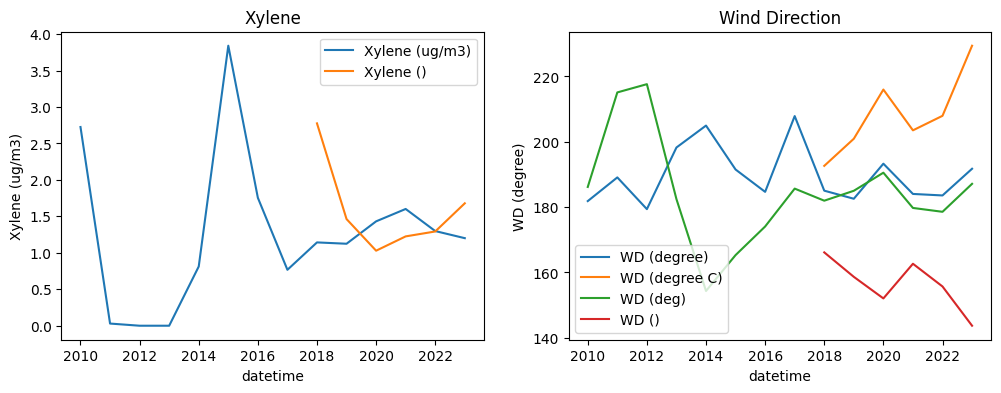

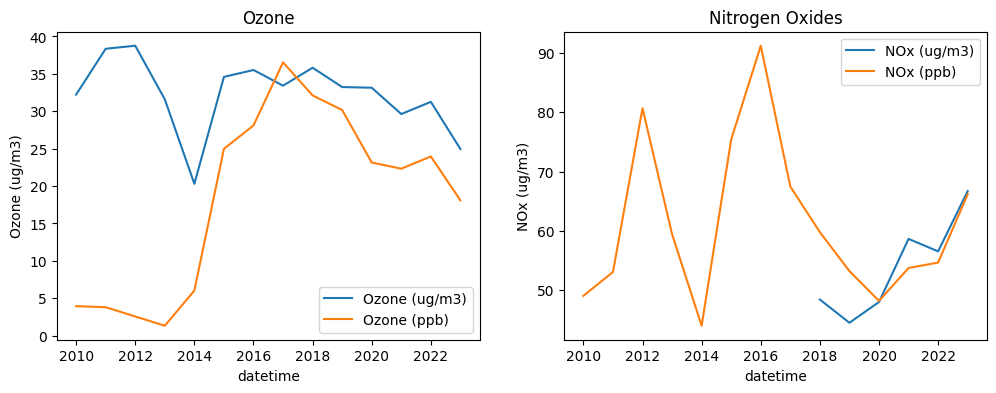

In [15]:
group1 = {
    'Xylene':          ['Xylene (ug/m3)', 'Xylene ()'],
    'Wind Direction':  ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
}

group2 = {
    'Ozone':           ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides': ['NOx (ug/m3)', 'NOx (ppb)'],
}

plot_features(df, group1)
plot_features(df, group2)

It seems like some of the features are capturing the same metric as others. This is a good indication and we can double confirm by using the pands describe.

In [16]:
print(df[group1['Xylene']].describe().applymap(lambda x: f"{x:0.3f}"), '\n')
print(df[group1['Wind Direction']].describe().applymap(lambda x: f"{x:0.3f}"), '\n')
print(df[group2['Ozone']].describe().applymap(lambda x: f"{x:0.3f}"), '\n')
print(df[group2['Nitrogen Oxides']].describe().applymap(lambda x: f"{x:0.3f}"), '\n')

      Xylene (ug/m3)  Xylene ()
count     242944.000  34578.000
mean           1.337      1.319
std            5.762      3.348
min            0.000      0.000
25%            0.000      0.000
50%            0.000      0.400
75%            1.010      1.400
max          476.310    231.000 

      WD (degree) WD (degree C)    WD (deg)       WD ()
count  813361.000     43888.000  655812.000  122463.000
mean      186.417       205.871     184.905     157.480
std        94.905        88.418      80.286      91.992
min         0.020         1.200       0.030       1.300
25%       104.850       119.570     121.010      86.950
50%       187.380       230.435     185.310     147.830
75%       268.950       285.550     252.050     229.700
max       360.000       356.520     359.590     359.700 

      Ozone (ug/m3) Ozone (ppb)
count   1874697.000   47576.000
mean         32.370      25.864
std          34.778      19.535
min           0.010       0.050
25%           8.550      13.530
50%         

As it seems I was able to merge the following features. The rest have too many missing values so we are going to drop them.

In [19]:
transfer_metrics = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [17]:
def fill_column(df, column, cols_to_integrate):
    # Check if the original column exist, otherwise create it
    if column not in df.columns and any(name in df.columns for name in cols_to_integrate):
        df[column] = np.nan

    for col_name in cols_to_integrate:
        if col_name in df.columns:
            df[column] = df[column].fillna(df[col_name])
            df.drop(columns=[col_name], inplace=True)

In [20]:
for col, extra_col in transfer_metrics.items():
    fill_column(df, col, extra_col)

In [21]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6

df.dropna(thresh=df.shape[0]*threshold, axis=1, inplace=True)

In [22]:
compare_nulls(df)

,Records,Null Count,Percent Missing (%)
BP (mmHg),1379037,740617,34.94
NH3 (ug/m3),1429357,690297,32.57
Toluene (ug/m3),1482308,637346,30.07
Benzene (ug/m3),1533313,586341,27.66
SR (W/mt2),1555347,564307,26.62
WS (m/s),1596858,522796,24.66
RH (%),1611483,508171,23.97
PM10 (ug/m3),1627629,492025,23.21
WD (degree),1635524,484130,22.84
SO2 (ug/m3),1674418,445236,21.01


## Exploratory Data Analysis (EDA)

In [38]:
pollutants = {
    # A mixture of solid particles and liquid droplets found in the air.
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    # Nitrogen gases form when fuel is burned at high temperatures.
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    # These are found in coal tar, crude petroleum, paint, vehicle exhausts and industrial emissions.
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    # Released from the partial combustion of carbon-containing compounds.
    'Carbon Monoxide': ['CO (mg/m3)'],

    # Released naturally by volcanic activity and is produced as a by-product of copper extraction and the burning of sulfur-bearing fossil fuels.
    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    # It is created mostly the combustion of fossil fuels.
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    # Affects Earth's average temperatures
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}


### Visualizations

In [131]:
def plot_metrics(dataframe, metric, group, markers=False, dashes=False, figsize=(12,4)):
    plt.figure(figsize=figsize)

    df_metrics = dataframe[dataframe.columns.intersection(group[metric])]
    if not df_metrics.empty:
        sns.lineplot(data=df_metrics, markers=markers, dashes=dashes)
        plt.title(metric)
    plt.plot()

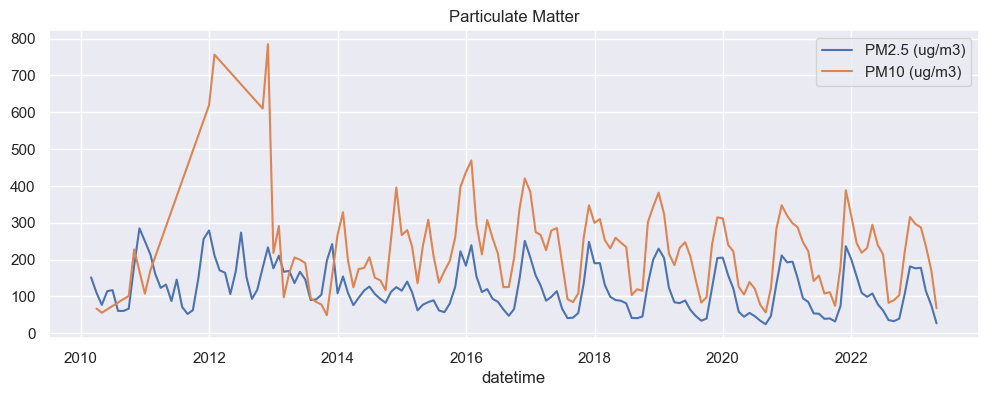

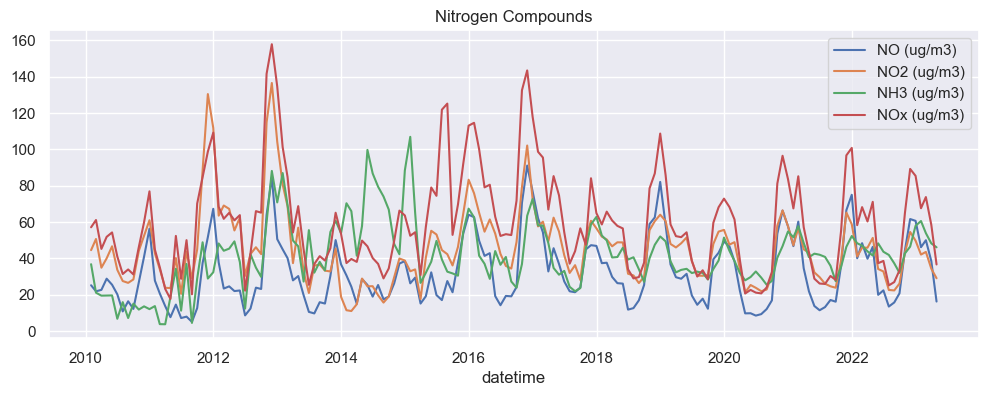

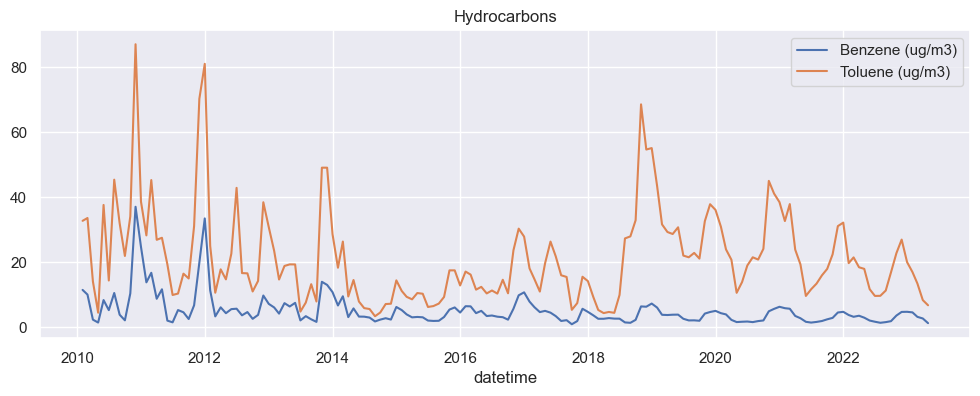

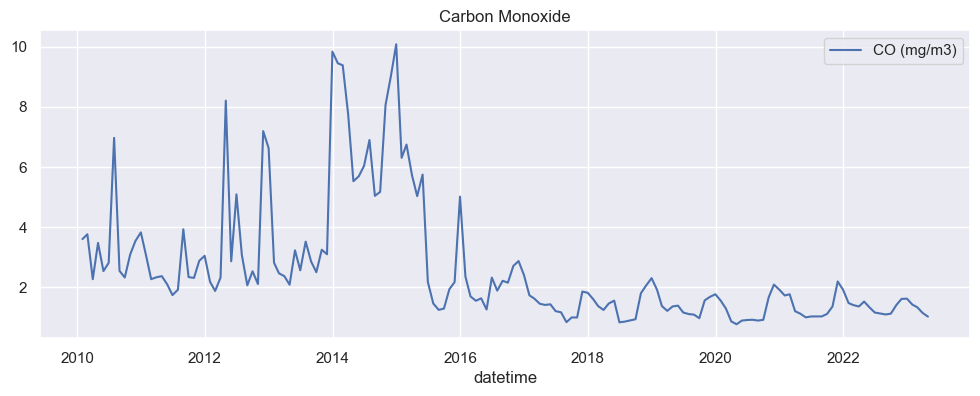

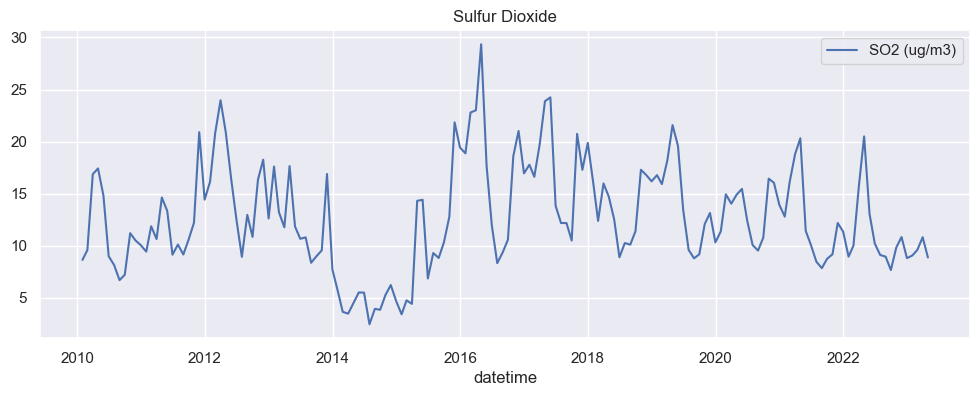

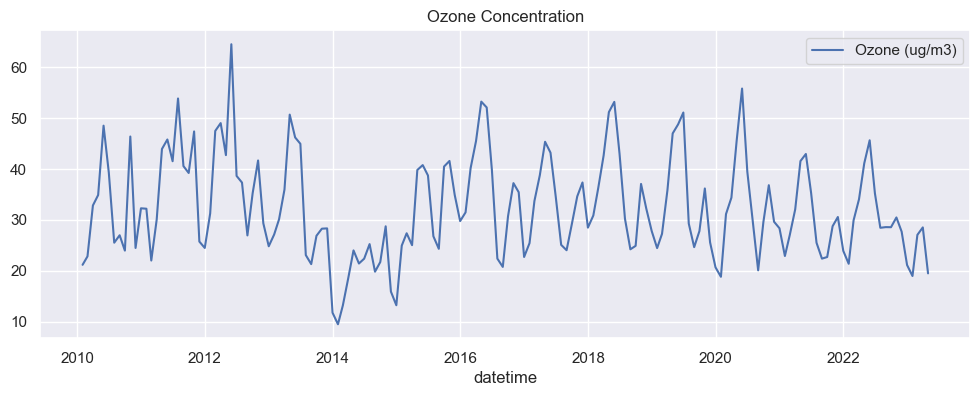

In [136]:
df_pollution = df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True)
#df_pollution = df.groupby([df.index.year]).mean(numeric_only=True)

for metric in pollutants:
    plot_metrics(df_pollution, metric=metric, group=pollutants)

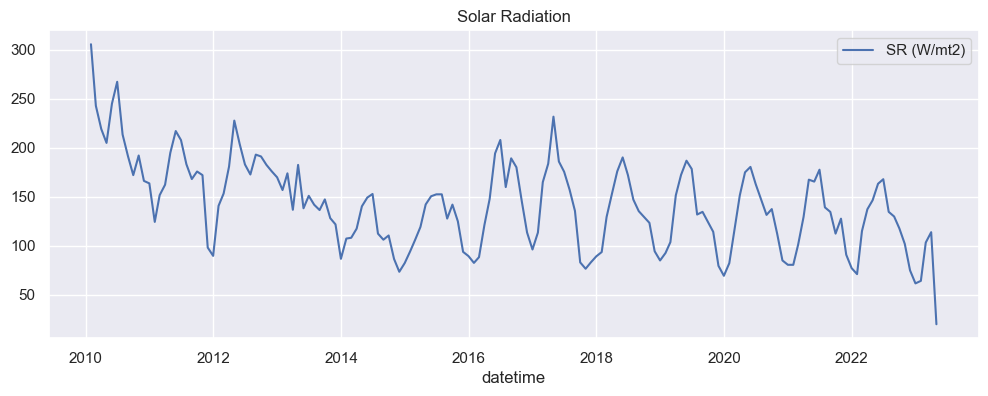

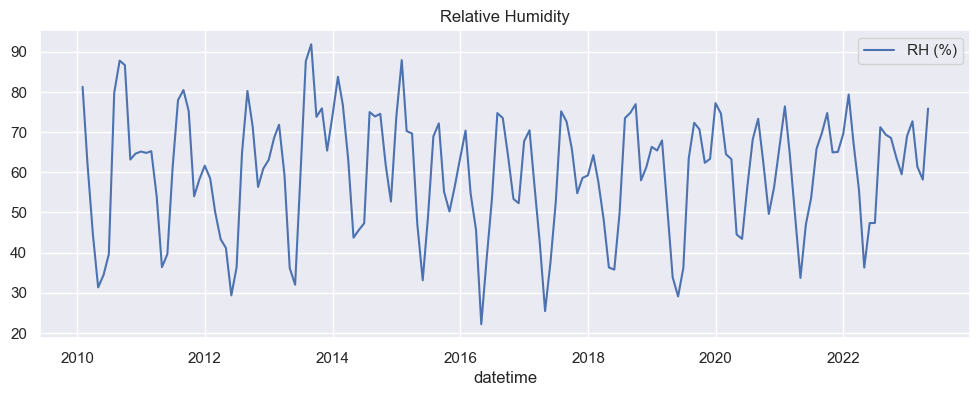

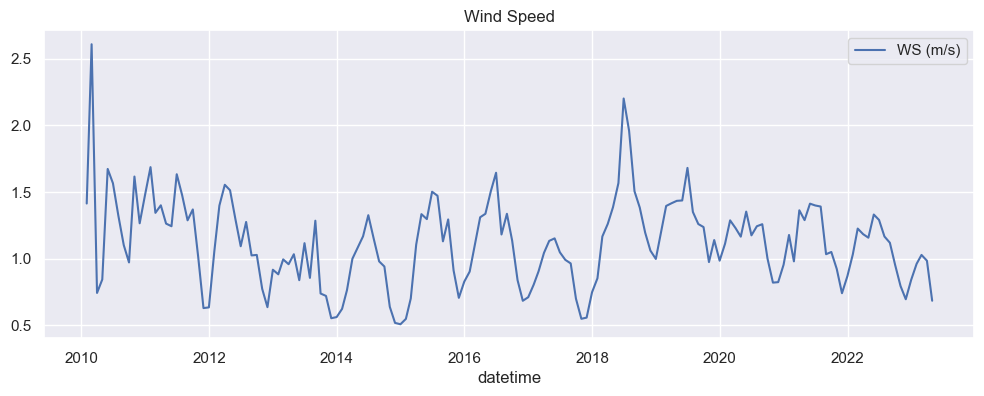

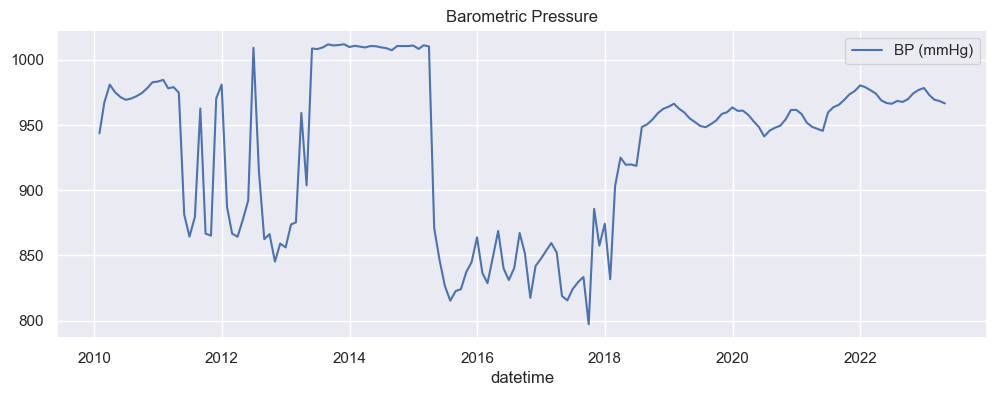

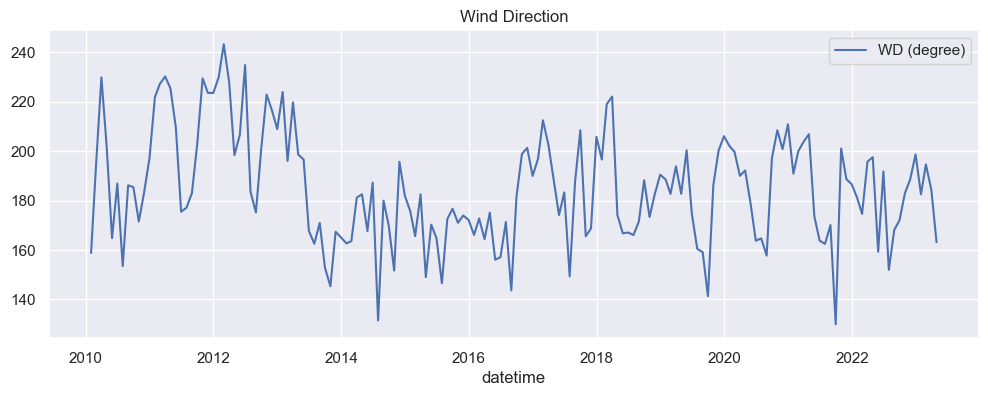

In [133]:
plot_metrics(df_pollution, metric='Solar Radiation', group=other_metrics)
plot_metrics(df_pollution, metric='Relative Humidity', group=other_metrics)
plot_metrics(df_pollution, metric='Wind Speed', group=other_metrics)
plot_metrics(df_pollution, metric='Barometric Pressure', group=other_metrics)
plot_metrics(df_pollution, metric='Wind Direction', group=other_metrics)

### Correlation Matrix

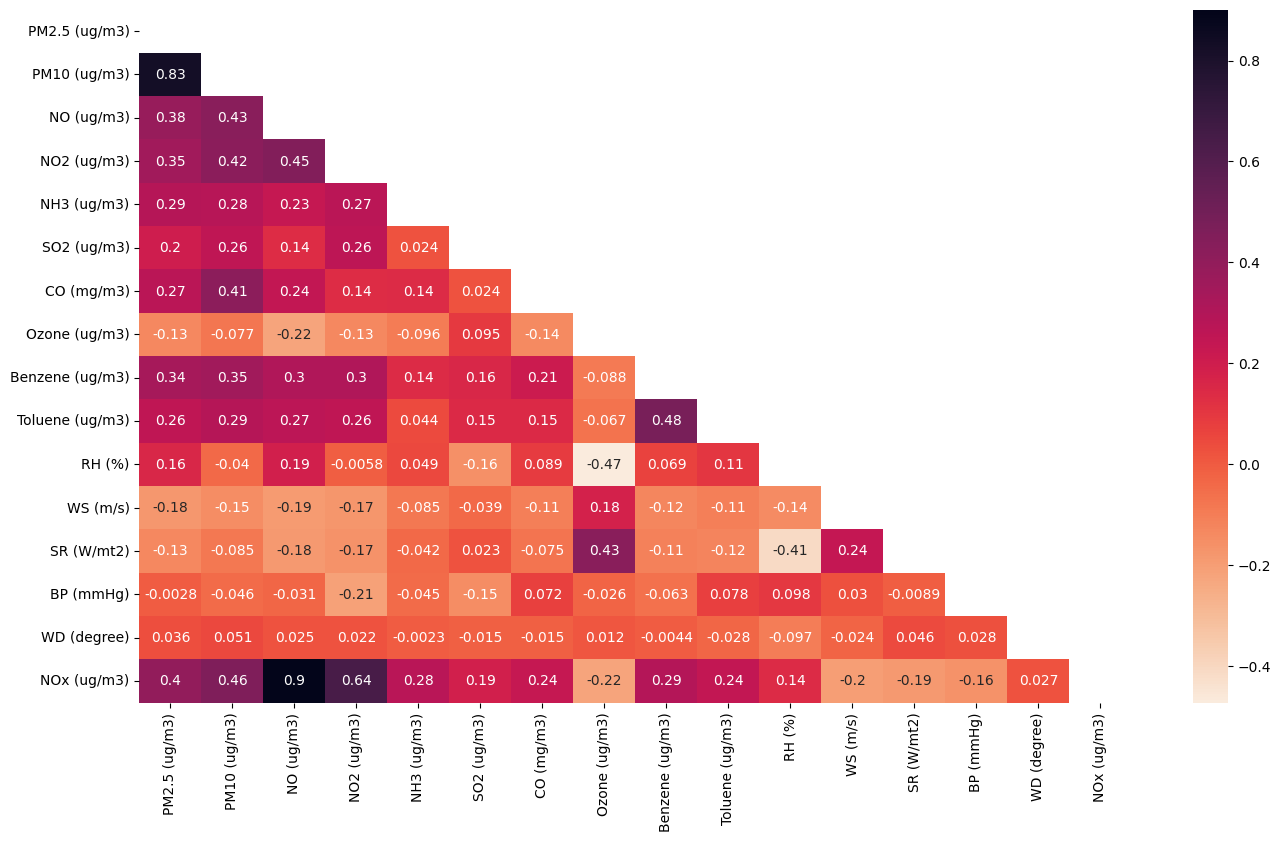

In [80]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,9))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()